## Isolation Forest Model for Credit Card Fraud Detection

In [ ]:
## Logger configuration
from loguru import logger

logger.remove()

logger.add("logs/ocsvm.log",
           level = "DEBUG",
           format = "{time:HH:mm:ss} | {level} | {message}")

## Load and Sample Data

In [2]:
import pandas as pd 
from sklearn.model_selection import train_test_split

df = pd.read_csv("../creditcard.csv")

target_feature = "Class"
input_features = list(df.columns)
input_features.remove(target_feature)

df_sampled, _ = train_test_split(df, 
                                test_size = 0.3, 
                                stratify = df['Class'], 
                                random_state = 42)

## Split and Scale Data

In [6]:
from sklearn.preprocessing import StandardScaler

# Split the data into features 'X' and target 'y'
X = df[input_features]
y = df[target_feature]

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Apply data scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Create and Train Model

- [SKLearn - IsolationForest Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.83      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.89      0.53     56962
weighted avg       1.00      0.96      0.98     56962



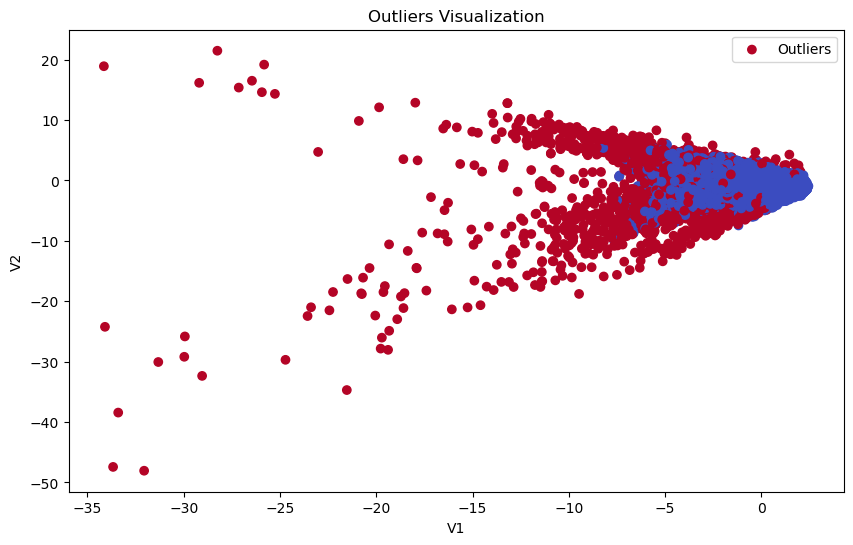

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


# Train the Isolation Forest model
isolation_forest = IsolationForest(contamination = 'auto', random_state = 42)
isolation_forest.fit(X_train_scaled)

# Predict outliers on the test set
outliers = isolation_forest.predict(X_test_scaled)
outliers = (outliers == -1).astype(int)

# Add predictions to the test set DataFrame
df_test = X_test.copy()
df_test['Outliers'] = outliers
df_test['Class'] = y_test



In [16]:
df_test.shape

(56962, 32)

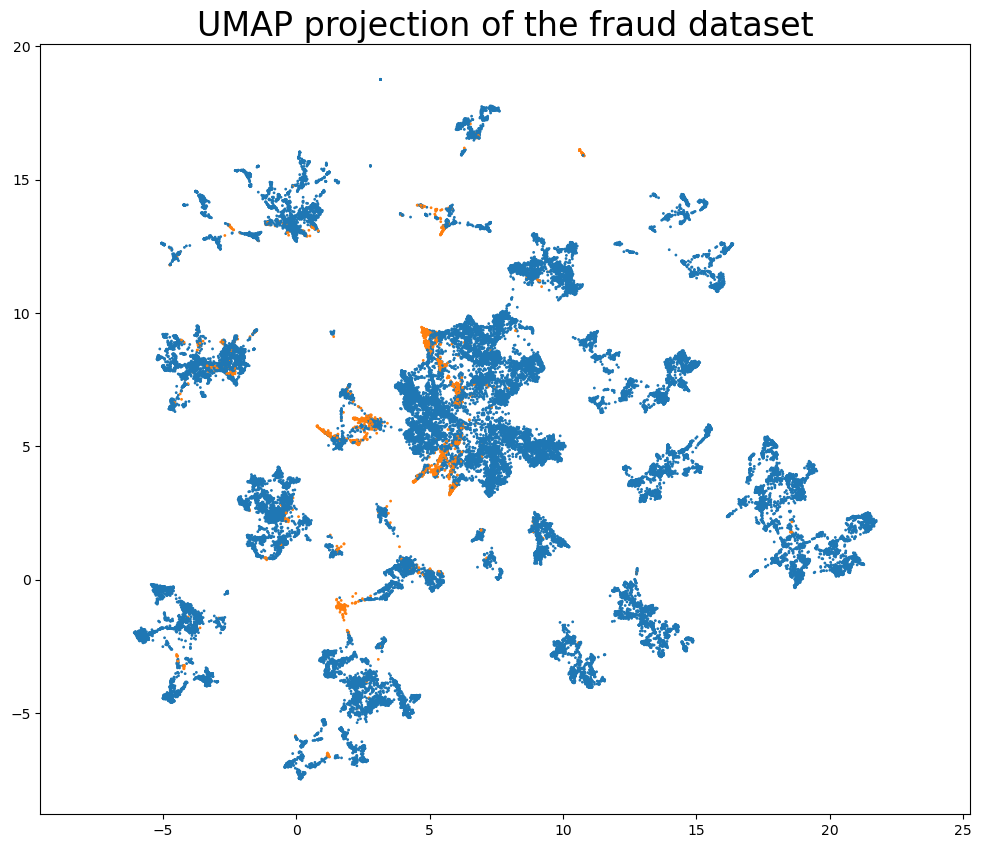

None


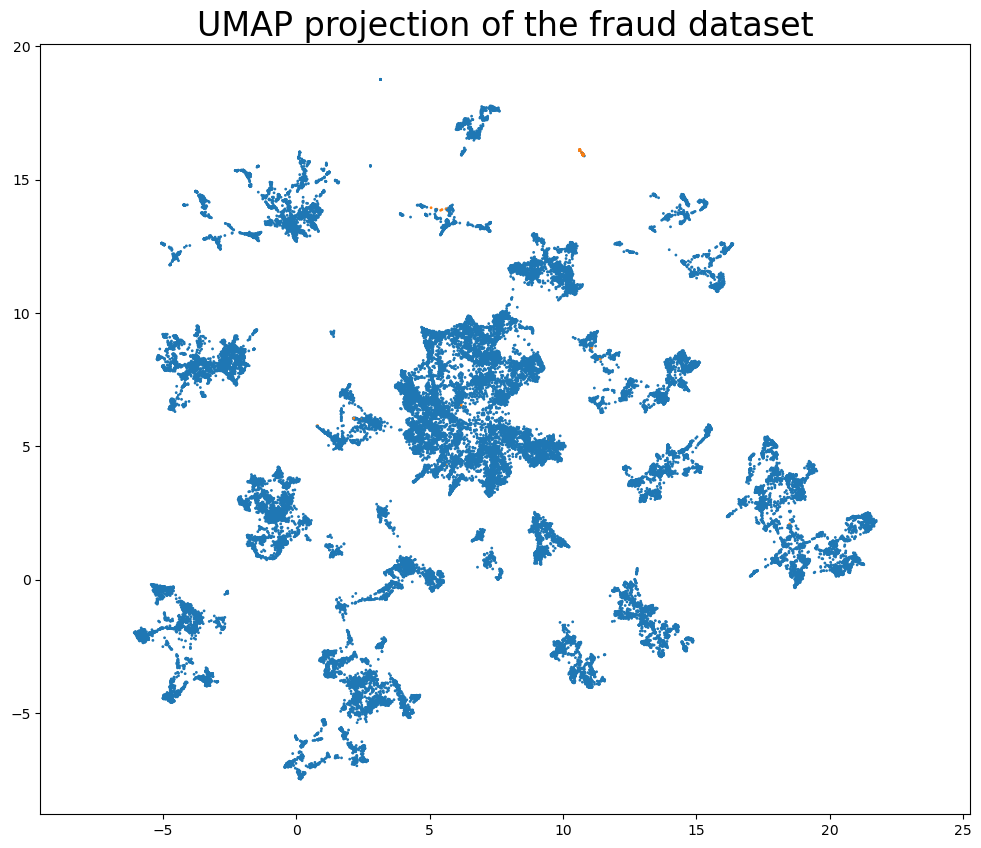

None


In [15]:
# Display the outliers
from sklearn.preprocessing import StandardScaler
import umap

# sampled_df = df.sample(n = 100000)
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_test_scaled)

import matplotlib.pyplot as plt 
import seaborn as sns

def umap_scatter_plot(embedding, df_class_column):

    if embedding.ndim == 2 and embedding.shape[1] >= 2:
        
        plt.figure(figsize=(12, 10))
        colours = [sns.color_palette()[x] for x in df_class_column]
                
        plt.scatter(
            x = embedding[:, 0],
            y = embedding[:, 1],
            c = colours,
            s = 1
            )

        plt.gca().set_aspect('equal', 'datalim')
        plt.title('UMAP projection of the fraud dataset', fontsize = 24)
        plt.show()
        
        
    else: 
        print("Error: `embedding` should be a 2-dimensional array with at least 2 columns.")
        
        
print(umap_scatter_plot(embedding, df_test["Outliers"]))
print(umap_scatter_plot(embedding, df_test["Class"]))


## Apply model to full dataset

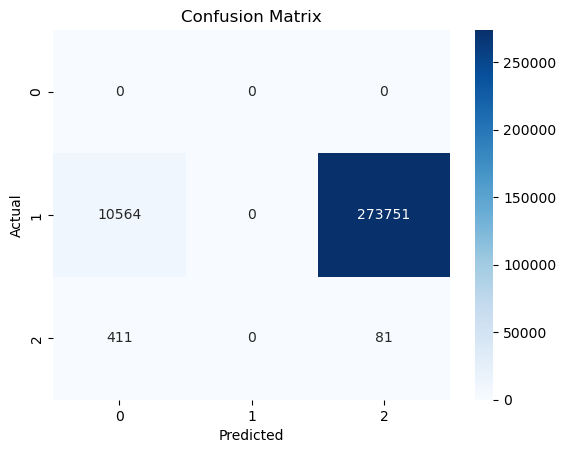

In [22]:
X_full = df[input_features]
y_full = df[target_feature]


df_full = scaler.fit_transform(X_full)
predictions = isolation_forest.predict(df_full)


df_test = X_full.copy()
df_test["Class"] = y_full
df_test["Prediction"] = predictions


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_val, y_pred):
    
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
plot_confusion_matrix(df_test["Class"], df_test["Prediction"])





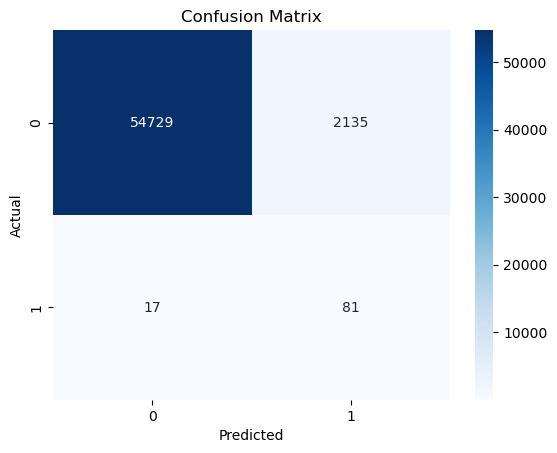

In [8]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_val, y_pred):
    
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
plot_confusion_matrix(y_test, outliers)

In [ ]:
from sklearn.preprocessing import StandardScaler
import umap

# sampled_df = df.sample(n = 100000)
scaled_df = StandardScaler().fit_transform(df.drop("Class", axis = 1))

reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_df)